In [2]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
# import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_pickle('./data.pickle')

In [4]:
select_features = ['user_id','cp_server_no','cp_role_id','role_created_3_login_num',
       'role_created_3_active', 'role_created_3_online',
       'role_created_3_max_role_level', 'role_created_3_ip_num',
       'role_created_3_device_num',
       'role_created_3_pay_num', 'role_created_3_pay_sum', 'active_0-8', 'active_8-12', 'active_12-14',
       'active_14-18', 'active_18-24', 'pay_grade_1', 'pay_grade_2',
       'pay_grade_3', 'pay_grade_4', 'pay_grade_5', 'pay_grade_6',
       'role_created_3_pay_rate', 'role_created_3_pay_avg',
       'model_money_level', 'hour', 'weekend', 'is_holidays','mobile','platform',
       'user_creates_3_server_num','user_creates_3_role_num', 'time_interval']
label = ['role_created_30_pay_sum']
df = data[select_features].join(data[label])
df['role_created_30_pay_sum'].fillna(0,inplace=True)
df['platform'].fillna(0,inplace=True)
df['user_creates_3_server_num'].fillna(1,inplace=True)
df['user_creates_3_role_num'].fillna(1,inplace=True)
df['time_interval'].fillna(0,inplace=True)
df['model_money_level'].fillna(4,inplace=True)

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,user_id,cp_server_no,cp_role_id,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_pay_num,role_created_3_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,mobile,platform,user_creates_3_server_num,user_creates_3_role_num,time_interval,role_created_30_pay_sum
0,90001783,660011,12927595,1.0,1.0,7288.0,8.0168,1.0,1.0,0.0,0.0,0,0,15,10,0,0,0,0,0,0,0,0.0,0.0,0.0,13,4,0,0,1.0,1.0,2.0,0.0,0.0
1,90001801,660011,12927596,1.0,1.0,907.0,1.0000,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0.0
2,89947274,660011,12927597,3.6,1.0,907.0,1.0000,1.0,1.0,0.0,0.0,0,0,2,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,2.0,2.0,3.0,0.0
3,90001815,660011,12927598,1.0,1.0,907.0,1.0000,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,1.0,13,4,0,0,1.0,1.0,1.0,0.0,0.0
4,90001842,660011,12927599,10.8,1.0,2437.0,2.6807,1.0,1.0,0.0,0.0,0,0,9,0,0,0,0,0,0,0,0,0.0,0.0,3.0,13,4,0,0,1.0,1.0,1.0,0.0,0.0


In [10]:
df.shape

(5078416, 34)

In [11]:
df_3_pay = df[df['role_created_3_pay_sum']>0]
df_3_nopay = df[df['role_created_3_pay_sum']==0]

In [12]:
df_3_pay['role_created_30_pay_sum'].sum()

93439049.0

In [13]:
df_3_nopay['role_created_30_pay_sum'].sum()

5396494.0

In [461]:
index = df_3_nopay['role_created_30_pay_sum'].sort_values(ascending=False)[:100].index

In [462]:
df_3_nopay.loc[index,:]

,user_id,cp_server_no,cp_role_id,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_pay_num,role_created_3_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,mobile,platform,user_creates_3_server_num,user_creates_3_role_num,time_interval,role_created_30_pay_sum
4935039,114676030,660893,18106033,18.0,3.0,56573.0,56.0000,3.0,1.0,0.0,0.0,26,56,48,57,35,0,0,0,0,0,0,0.0,0.0,10.0,10,2,0,0,1.0,1.0,1.0,0.0,107934.0
1780515,104999457,660368,15089134,41.0,3.0,22871.0,25.1581,3.0,1.0,0.0,0.0,25,31,4,22,22,0,0,0,0,0,0,0.0,0.0,10.0,0,5,0,0,2.0,1.0,1.0,0.0,53532.0
36265,91982455,660020,12967310,65.0,3.0,86400.0,64.0000,3.0,1.0,0.0,0.0,123,67,9,69,81,0,0,0,0,0,0,0.0,0.0,4.0,23,5,0,0,1.0,2.0,2.0,3.0,45884.0
4872307,114461891,660882,18043296,11.0,3.0,36666.0,54.0000,5.0,1.0,0.0,0.0,11,36,8,26,31,0,0,0,0,0,0,0.0,0.0,4.0,17,5,0,0,1.0,2.0,2.0,2.0,39564.0
2349031,106647339,660454,15645864,55.0,3.0,44927.0,49.4197,4.0,1.0,0.0,0.0,18,62,0,44,61,0,0,0,0,0,0,0.0,0.0,5.0,17,3,0,0,2.0,1.0,1.0,0.0,38470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4852076,114408260,S880,18027878,13.0,2.0,2402.0,34.0000,2.0,1.0,0.0,0.0,0,0,0,15,6,0,0,0,0,0,0,0.0,0.0,10.0,16,4,0,0,2.0,1.0,1.0,0.0,7452.0
3321352,109395628,660592,16583454,2.0,1.0,907.0,1.0000,2.0,1.0,0.0,0.0,0,3,1,0,0,0,0,0,0,0,0,0.0,0.0,4.0,12,2,0,0,1.0,1.0,1.0,0.0,7402.0
4904030,114579298,660887,18076880,9.0,2.0,12904.0,29.0000,2.0,1.0,0.0,0.0,0,6,21,27,0,0,0,0,0,0,0,0.0,0.0,4.0,13,0,0,1,1.0,1.0,1.0,0.0,7220.0
4880222,113646448,S883,18054380,26.0,3.0,18948.0,44.0000,1.0,1.0,0.0,0.0,18,22,0,28,2,0,0,0,0,0,0,0.0,0.0,6.0,2,6,0,0,1.0,1.0,1.0,6.0,7082.0


In [14]:
df_3_nopay_online_n = df_3_nopay[(df_3_nopay['role_created_3_online']==907) | (df_3_nopay['role_created_3_login_num']<3)|(df_3_nopay['role_created_3_max_role_level']==1)]
df_3_nopay_online_y = df_3_nopay.loc[np.setdiff1d(df_3_nopay.index, df_3_nopay_online_n.index),:]

In [15]:
print('前3天没有付费的人数：',df_3_nopay.shape[0])
print('前3天没有付费且不活跃的用户:',df_3_nopay_online_n.shape[0])
print('前3天没有付费但活跃的用户:',df_3_nopay_online_y.shape[0])

前3天没有付费的人数： 4972920
前3天没有付费且不活跃的用户: 4090900
前3天没有付费但活跃的用户: 882020


In [16]:
print('前3天没有付费且不活跃的用户30天付费金额:', df_3_nopay_online_n['role_created_30_pay_sum'].sum())
print('前3天没有付费但活跃的用户30天付费金额:', df_3_nopay_online_y['role_created_30_pay_sum'].sum())
print('前3天没有付费但前30天付费的用户人数:',df_3_nopay_online_y[df_3_nopay_online_y['role_created_30_pay_sum']>0].shape[0])
print('前3天没有付费但前30天付费的用户人数前30天付费金额:',df_3_nopay_online_y[df_3_nopay_online_y['role_created_30_pay_sum']>0]['role_created_30_pay_sum'].mean())

前3天没有付费且不活跃的用户30天付费金额: 642298.0
前3天没有付费但活跃的用户30天付费金额: 4754196.0
前3天没有付费但前30天付费的用户人数: 19288
前3天没有付费但前30天付费的用户人数前30天付费金额: 246.48465367067607


In [17]:
df_train, df_test = train_test_split(df,test_size=0.3)

In [18]:
df_train_3_pay = df_train[df_train['role_created_3_pay_sum']>0]
df_train_3_nopay = df_train[df_train['role_created_3_pay_sum']==0]
df_train_3_nopay_online_n = df_train_3_nopay[(df_train_3_nopay['role_created_3_online']==907) | (df_train_3_nopay['role_created_3_login_num']<3)|(df_train_3_nopay['role_created_3_max_role_level']==1)]
df_train_3_nopay_online_y = df_train_3_nopay.loc[np.setdiff1d(df_train_3_nopay.index, df_train_3_nopay_online_n.index),:]

# 在前3天没有付费但活跃的用户中，预测前30天是否会成为付费用户

In [217]:
df_train_3_nopay_online_y.head()

,user_id,cp_server_no,cp_role_id,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_pay_num,role_created_3_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,mobile,platform,user_creates_3_server_num,user_creates_3_role_num,time_interval,role_created_30_pay_sum
6,90001889,660011,12927601,8.0,2.0,14538.0000,37.0000,3.0,1.0,0.0,0.0,3,5,17,19,2,0,0,0,0,0,0,0.0,0.0,1.0,13,4,0,0,1.0,1.0,1.0,0.0,0.0
7,90001891,660011,12927602,7.2,1.0,1349.8881,1.4883,1.0,1.0,0.0,0.0,0,0,5,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0.0
16,81881843,660011,12927611,8.4,1.0,1497.5477,1.6511,1.0,1.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0.0,0.0,0.0,13,4,0,0,1.0,1.0,1.0,7.0,0.0
18,90002408,660011,12927613,9.6,1.0,1721.0325,1.8975,1.0,1.0,0.0,0.0,0,0,5,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0.0
19,90002420,660011,12927614,3.0,2.0,4286.0000,21.0000,2.0,2.0,0.0,0.0,0,0,9,6,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0.0


In [218]:
df_train_3_nopay_online_y.shape

(617301, 34)

In [219]:
df_train_3_nopay_online_y['pay_30'] = (df_train_3_nopay_online_y['role_created_30_pay_sum']>0).astype(int)
df_train_3_nopay_online_y.drop(['role_created_30_pay_sum'], axis=1, inplace=True)
df_train_3_nopay_online_y.head()

,user_id,cp_server_no,cp_role_id,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_pay_num,role_created_3_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,mobile,platform,user_creates_3_server_num,user_creates_3_role_num,time_interval,pay_30
6,90001889,660011,12927601,8.0,2.0,14538.0000,37.0000,3.0,1.0,0.0,0.0,3,5,17,19,2,0,0,0,0,0,0,0.0,0.0,1.0,13,4,0,0,1.0,1.0,1.0,0.0,0
7,90001891,660011,12927602,7.2,1.0,1349.8881,1.4883,1.0,1.0,0.0,0.0,0,0,5,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0
16,81881843,660011,12927611,8.4,1.0,1497.5477,1.6511,1.0,1.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0.0,0.0,0.0,13,4,0,0,1.0,1.0,1.0,7.0,0
18,90002408,660011,12927613,9.6,1.0,1721.0325,1.8975,1.0,1.0,0.0,0.0,0,0,5,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0
19,90002420,660011,12927614,3.0,2.0,4286.0000,21.0000,2.0,2.0,0.0,0.0,0,0,9,6,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0


In [19]:
df_train_3_nopay_online_y['pay_30'].value_counts()

0    604715
1     13429
Name: pay_30, dtype: int64

In [49]:
target = df_train_3_nopay_online_y['pay_30']
features = df_train_3_nopay_online_y.drop(['pay_30'], axis=1)

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()         #实例化，不填参数默认方差为0
features = selector.fit_transform(features)         #获取删除不合格特征之后的新特征矩阵

# from imblearn.over_sampling import SMOTE
# smo = SMOTE(random_state=0)
# features, target = smo.fit_sample(features, target)

# from imblearn.under_sampling import SMOTE
# # from imblearn.over_sampling import SMOTE
# smo = SMOTE(random_state=0)
# features, target = smo.fit_sample(features, target)

In [42]:
target.value_counts()

0    604715
1     13429
Name: pay_30, dtype: int64

In [50]:
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [35]:
# from imblearn.over_sampling import SMOTE
# smo = SMOTE(random_state=0)
# X_val, Y_val = smo.fit_sample(X_val, Y_val)
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_val, Y_val = rus.fit_resample(X_val, Y_val)

In [51]:
thresholds = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
thresholds_2 = thresholds[:]

print(thresholds_2)
result_model_f1 = pd.DataFrame(index=thresholds_2)
print(result_model_f1)

[0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
Empty DataFrame
Columns: []
Index: [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]


In [52]:
Y_val.value_counts()

0    423229
1      9471
Name: pay_30, dtype: int64

In [ ]:
# from sklearn.svm import SVC
# svc = SVC(kernel='linear', class_weight='balanced',probability=True)

# svc.fit(X_val, Y_val)
# y_predict = svc.predict(x_test)
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# print('召回率recall_score:',recall_score(y_test.values, y_predict, average=None))
# print('精确率precision_score:',precision_score(y_test.values, y_predict))
# print('准确率accruacy_score:',accuracy_score(y_test.values, y_predict))
# print('f1_score:',f1_score(y_test.values, y_predict))
# plt.figure(figsize=(12, 8), dpi=120)
# plot_confusion_matrix(gbdt_b,x_test, y_test)
# plt.show()

In [53]:
# 不调参
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.03,
"max_depth":3,
"num_leaves":35,
"min_child_samples":15,
"feature_fraction": 0.7,
"bagging_fraction":0.7,
"bagging_freq":10,
"lambda_l1":1,
"lambda_l2":2,
"metric": "auc",
"is_unbalance":True
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.829458	valid_1's auc: 0.828568
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.84068	valid_1's auc: 0.838941
[3]	training's auc: 0.844595	valid_1's auc: 0.84256
[4]	training's auc: 0.845559	valid_1's auc: 0.843596
[5]	training's auc: 0.847285	valid_1's auc: 0.845561
[6]	training's auc: 0.847801	valid_1's auc: 0.845846
[7]	training's auc: 0.848684	valid_1's auc: 0.846786
[8]	training's auc: 0.849132	valid_1's auc: 0.847251
[9]	training's auc: 0.8494	valid_1's auc: 0.847526
[10]	training's auc: 0.849664	valid_1's auc: 0.847694
[11]	training's auc: 0.849838	valid_1's auc: 0.847791
[12]	training's auc: 0.850034	valid_1's auc: 0.848001
[13]	training's auc: 0.850228	valid_1's auc: 0.848285
[14]	training's auc: 0.850382	valid_1's auc: 0.848484
[15]	training's auc: 0.850613	valid_1's auc: 0.8487
[16]	training's auc: 0.851004	valid_1's auc: 0.849078
[17]	training's auc: 0.851143	valid_1's auc: 0.849185
[18]	training's auc: 0.851327	valid

[158]	training's auc: 0.858746	valid_1's auc: 0.855076
[159]	training's auc: 0.858753	valid_1's auc: 0.855078
[160]	training's auc: 0.858758	valid_1's auc: 0.855076
[161]	training's auc: 0.858806	valid_1's auc: 0.855104
[162]	training's auc: 0.858821	valid_1's auc: 0.855108
[163]	training's auc: 0.858834	valid_1's auc: 0.855107
[164]	training's auc: 0.858889	valid_1's auc: 0.855129
[165]	training's auc: 0.858902	valid_1's auc: 0.855127
[166]	training's auc: 0.85899	valid_1's auc: 0.855166
[167]	training's auc: 0.859042	valid_1's auc: 0.855183
[168]	training's auc: 0.859058	valid_1's auc: 0.855188
[169]	training's auc: 0.859075	valid_1's auc: 0.855188
[170]	training's auc: 0.859141	valid_1's auc: 0.855217
[171]	training's auc: 0.859164	valid_1's auc: 0.85523
[172]	training's auc: 0.859191	valid_1's auc: 0.855233
[173]	training's auc: 0.859211	valid_1's auc: 0.855245
[174]	training's auc: 0.859229	valid_1's auc: 0.855253
[175]	training's auc: 0.859242	valid_1's auc: 0.855254
[176]	traini

[310]	training's auc: 0.862152	valid_1's auc: 0.856194
[311]	training's auc: 0.862165	valid_1's auc: 0.856191
[312]	training's auc: 0.862191	valid_1's auc: 0.856207
[313]	training's auc: 0.862206	valid_1's auc: 0.856217
[314]	training's auc: 0.862231	valid_1's auc: 0.856229
[315]	training's auc: 0.862262	valid_1's auc: 0.856257
[316]	training's auc: 0.862278	valid_1's auc: 0.85628
[317]	training's auc: 0.86229	valid_1's auc: 0.856292
[318]	training's auc: 0.862318	valid_1's auc: 0.856308
[319]	training's auc: 0.86234	valid_1's auc: 0.856305
[320]	training's auc: 0.862352	valid_1's auc: 0.856324
[321]	training's auc: 0.862366	valid_1's auc: 0.856307
[322]	training's auc: 0.862385	valid_1's auc: 0.856304
[323]	training's auc: 0.862403	valid_1's auc: 0.856302
[324]	training's auc: 0.862426	valid_1's auc: 0.85631
[325]	training's auc: 0.862451	valid_1's auc: 0.856323
[326]	training's auc: 0.862466	valid_1's auc: 0.856335
[327]	training's auc: 0.862489	valid_1's auc: 0.85635
[328]	training'

[462]	training's auc: 0.864564	valid_1's auc: 0.856925
[463]	training's auc: 0.864587	valid_1's auc: 0.856928
[464]	training's auc: 0.864604	valid_1's auc: 0.856936
[465]	training's auc: 0.864619	valid_1's auc: 0.856924
[466]	training's auc: 0.864631	valid_1's auc: 0.85693
[467]	training's auc: 0.864638	valid_1's auc: 0.856933
[468]	training's auc: 0.864651	valid_1's auc: 0.856929
[469]	training's auc: 0.864667	valid_1's auc: 0.856923
[470]	training's auc: 0.864676	valid_1's auc: 0.856927
[471]	training's auc: 0.864693	valid_1's auc: 0.856924
[472]	training's auc: 0.864708	valid_1's auc: 0.856921
[473]	training's auc: 0.864723	valid_1's auc: 0.856926
[474]	training's auc: 0.864737	valid_1's auc: 0.856924
[475]	training's auc: 0.86475	valid_1's auc: 0.856924
[476]	training's auc: 0.864769	valid_1's auc: 0.856932
[477]	training's auc: 0.864781	valid_1's auc: 0.856933
[478]	training's auc: 0.864796	valid_1's auc: 0.856932
[479]	training's auc: 0.864812	valid_1's auc: 0.856934
[480]	traini

[614]	training's auc: 0.866533	valid_1's auc: 0.857185
[615]	training's auc: 0.866552	valid_1's auc: 0.857187
[616]	training's auc: 0.86657	valid_1's auc: 0.857189
[617]	training's auc: 0.866582	valid_1's auc: 0.857196
[618]	training's auc: 0.866597	valid_1's auc: 0.857191
[619]	training's auc: 0.866607	valid_1's auc: 0.857195
[620]	training's auc: 0.866615	valid_1's auc: 0.857195
[621]	training's auc: 0.866625	valid_1's auc: 0.857193
[622]	training's auc: 0.866632	valid_1's auc: 0.857199
[623]	training's auc: 0.866643	valid_1's auc: 0.857203
[624]	training's auc: 0.86665	valid_1's auc: 0.8572
[625]	training's auc: 0.866659	valid_1's auc: 0.857201
[626]	training's auc: 0.866665	valid_1's auc: 0.857201
[627]	training's auc: 0.866677	valid_1's auc: 0.857195
[628]	training's auc: 0.866684	valid_1's auc: 0.85719
[629]	training's auc: 0.866698	valid_1's auc: 0.857189
[630]	training's auc: 0.866709	valid_1's auc: 0.857186
[631]	training's auc: 0.866711	valid_1's auc: 0.857182
[632]	training'

[765]	training's auc: 0.867994	valid_1's auc: 0.857254
[766]	training's auc: 0.867999	valid_1's auc: 0.857252
[767]	training's auc: 0.868011	valid_1's auc: 0.857243
[768]	training's auc: 0.868025	valid_1's auc: 0.857241
[769]	training's auc: 0.86803	valid_1's auc: 0.85724
[770]	training's auc: 0.868044	valid_1's auc: 0.857243
[771]	training's auc: 0.868053	valid_1's auc: 0.857242
[772]	training's auc: 0.868059	valid_1's auc: 0.857244
[773]	training's auc: 0.868067	valid_1's auc: 0.857242
[774]	training's auc: 0.868073	valid_1's auc: 0.857242
[775]	training's auc: 0.868081	valid_1's auc: 0.857244
[776]	training's auc: 0.868088	valid_1's auc: 0.85724
[777]	training's auc: 0.868096	valid_1's auc: 0.85724
[778]	training's auc: 0.868106	valid_1's auc: 0.857238
[779]	training's auc: 0.868112	valid_1's auc: 0.857238
[780]	training's auc: 0.868122	valid_1's auc: 0.857235
[781]	training's auc: 0.868134	valid_1's auc: 0.857235
[782]	training's auc: 0.868148	valid_1's auc: 0.857233
[783]	training

In [54]:
# 用df_test数据集进行测试
df_test_3_pay = df_test[df_test['role_created_3_pay_sum']>0]
df_test_3_nopay = df_test[df_test['role_created_3_pay_sum']==0]
df_test_3_nopay_online_n = df_test_3_nopay[(df_test_3_nopay['role_created_3_online']==907) | (df_test_3_nopay['role_created_3_login_num']<3)|(df_test_3_nopay['role_created_3_max_role_level']==1)]
df_test_3_nopay_online_y = df_test_3_nopay.loc[np.setdiff1d(df_test_3_nopay.index, df_test_3_nopay_online_n.index),:]
df_test_3_nopay_online_y['pay_30'] = (df_test_3_nopay_online_y['role_created_30_pay_sum']>0).astype(int)
df_test_3_nopay_online_y.drop(['role_created_30_pay_sum'], axis=1, inplace=True)
# df_test_3_nopay_online_y.head()
target_test = df_test_3_nopay_online_y['pay_30']
features_test = df_test_3_nopay_online_y.drop(['pay_30'], axis=1)
features_test = selector.fit_transform(features_test)  
y_predict = lgb_b.predict(features_test)

In [55]:
sessoin = pd.DataFrame(y_predict, columns=['pay_30'])
sessoin['pay_30']=sessoin['pay_30'].apply(lambda x:1 if x>=0.4 else 0)
y_predict_val = sessoin['pay_30'].values
print(recall_score(target_test, y_predict_val, average=None))
print(precision_score(target_test, y_predict_val))
print(accuracy_score(target_test, y_predict_val))
print(f1_score(target_test, y_predict_val))

[0.68603619 0.90356716]
0.06134272670390026
0.6908661644105565
0.11488590618591378


In [162]:
y_predict = gbdt_b.predict_proba(x_test)
# 调试不用的thresholds，当为0.35时f1最高
for i in thresholds:
    y_test_predictions_high_recall = y_predict[:,1] >= i
    result_model_f1.loc[i, 'GBDT'] = f1_score(y_test.values, y_test_predictions_high_recall)
print(result_model_f1)

          GBDT
0.10  0.122942
0.20  0.140007
0.25  0.144777
0.30  0.141001
0.35  0.134304
0.40  0.117468
0.45  0.089678
0.50  0.055973
0.55  0.022624
0.60  0.002938
0.65  0.000498
0.70  0.000000
0.75  0.000000
0.80  0.000000
0.85  0.000000
0.90  0.000000


# 前3天有付费的用户进行回归

In [19]:
df_train_3_pay.head()

,user_id,cp_server_no,cp_role_id,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_pay_num,role_created_3_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,mobile,platform,user_creates_3_server_num,user_creates_3_role_num,time_interval,role_created_30_pay_sum
1011191,102002206,660254,14262421,23.0,3.0,74074.0,56.0,6.0,1.0,1.0,12.0,75,30,6,11,84,0,1,0,0,0,0,0.333322,11.998800,3.0,19,5,0,0,1.0,1.0,1.0,0.0,12.0
3184857,108923797,660570,16452227,23.0,3.0,86400.0,62.0,5.0,1.0,30.0,2856.0,75,60,54,87,57,1,12,11,3,1,2,9.999667,95.199683,2.0,0,6,0,1,1.0,1.0,1.0,0.0,18708.0
2281828,106446060,660444,15579889,28.0,3.0,70541.0,56.0,3.0,1.0,1.0,30.0,87,56,15,23,32,0,1,0,0,0,0,0.333322,29.997000,2.0,23,1,0,1,1.0,4.0,4.0,0.0,30.0
259596,95846089,660064,13182226,25.0,3.0,31526.0,59.0,3.0,1.0,3.0,48.0,27,30,7,36,20,1,2,0,0,0,0,0.999967,15.999467,4.0,9,6,0,0,1.0,1.0,1.0,0.0,78.0
4093144,111878007,660744,17310771,4.0,1.0,19123.0,35.0,2.0,1.0,2.0,42.0,39,23,0,0,0,0,2,0,0,0,0,1.999800,20.998950,4.0,0,1,0,1,1.0,1.0,1.0,0.0,42.0


In [20]:
target = df_train_3_pay['role_created_30_pay_sum']
features = df_train_3_pay.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)

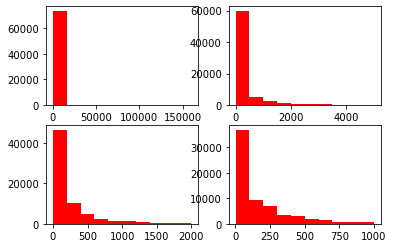

<Figure size 1600x800 with 0 Axes>

In [21]:
# 查看目标值的分布情况，大部分在4000以下
fig, axes = plt.subplots(2, 2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
fig = plt.figure(figsize=(20,10),dpi=80)
ax1.hist(target, color='red', range=(1, 160000))
ax2.hist(target, color='red', range=(1, 5000))
ax3.hist(target, color='red', range=(1, 2000))
ax4.hist(target, color='red', range=(1, 1000))
plt.show()

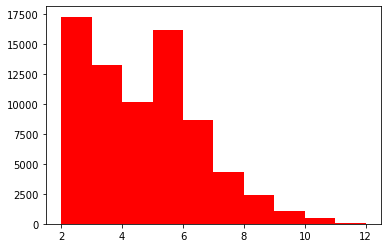

In [22]:
# 将target进行log1p转换
target_ln = np.log1p(target)
plt.hist(target_ln, color='red', range=(2, 12))
plt.show()

In [23]:
X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)

In [83]:
# lgb的调参与交叉验证
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# 设置参数初始值，不含交叉验证参数
print('设置参数')
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'nthread':4,
    'learning_rate':0.05
}

# 交叉验证（调参）
print('交叉验证')
min_rmse = float('2')
best_params = {}

# 准确率
print('调参1：提高准确率')
for num_leaves in range(5, 100, 5):
    for max_depth in range(3, 8, 1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth
        
        cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50     
                            )
        mean_rmse = pd.Series(cv_results['rmse-mean']).min()
        boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
        if mean_rmse <= min_rmse:
            min_rmse = mean_rmse
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth

if 'num_leaves' and 'max_depth' in best_params.keys():
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']

# 过拟合
print('调参2：降低过拟合')
for max_bin in range(5, 256, 10):
    for min_data_in_leaf in range(1, 102, 10):
        params['max_bin'] = max_bin
        params['min_data_in_leaf'] = min_data_in_leaf
        
        cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50 
                            )
        mean_rmse = pd.Series(cv_results['rmse-mean']).min()
        boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
        if mean_rmse <= min_rmse:
            min_rmse = mean_rmse
            best_params['min_data_in_leaf'] = min_data_in_leaf
            best_params['max_bin'] = max_bin
            
if 'max_bin' and 'min_data_in_leaf' in best_params.keys():
    params['max_bin'] = best_params['max_bin']
    params['min_data_in_leaf'] = best_params['min_data_in_leaf']

print('调参3：降低过拟合')
for feature_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for bagging_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        for bagging_freq in range(0,50,5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq

            cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50
                            )
            mean_rmse = pd.Series(cv_results['rmse-mean']).min()
            boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
            if mean_rmse <= min_rmse:
                min_rmse = mean_rmse
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq

if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']

print('调参4：降低过拟合')

for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
    for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50
                            )
        mean_rmse = pd.Series(cv_results['rmse-mean']).min()
        boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
        if mean_rmse <= min_rmse:
            min_rmse = mean_rmse
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print("调参5：降低过拟合2")
for min_split_gain in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    params['min_split_gain'] = min_split_gain
    
    cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50    
                            )
    mean_rmse = pd.Series(cv_results['rmse-mean']).min()
    boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
    if mean_rmse >= min_rmse:
        min_rmse = mean_rmse
        
    best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']
print(best_params)

设置参数
交叉验证
调参1：提高准确率
[50]	cv_agg's rmse: 0.976794 + 0.0115102
[100]	cv_agg's rmse: 0.950305 + 0.0130181
[50]	cv_agg's rmse: 0.976794 + 0.0115102
[100]	cv_agg's rmse: 0.95019 + 0.0130987
[50]	cv_agg's rmse: 0.976794 + 0.0115102
[100]	cv_agg's rmse: 0.95019 + 0.0130987
[50]	cv_agg's rmse: 0.976794 + 0.0115102
[100]	cv_agg's rmse: 0.95019 + 0.0130987
[50]	cv_agg's rmse: 0.976794 + 0.0115102
[100]	cv_agg's rmse: 0.95019 + 0.0130987
[50]	cv_agg's rmse: 0.967437 + 0.0116132
[100]	cv_agg's rmse: 0.948444 + 0.0128707
[50]	cv_agg's rmse: 0.964105 + 0.0112423
[100]	cv_agg's rmse: 0.947451 + 0.0128346
[50]	cv_agg's rmse: 0.964035 + 0.0113322
[100]	cv_agg's rmse: 0.94738 + 0.0129312
[50]	cv_agg's rmse: 0.964035 + 0.0113322
[100]	cv_agg's rmse: 0.947186 + 0.0130366
[50]	cv_agg's rmse: 0.964035 + 0.0113322
[100]	cv_agg's rmse: 0.947151 + 0.013043
[50]	cv_agg's rmse: 0.967437 + 0.0116132
[100]	cv_agg's rmse: 0.948444 + 0.0128707
[50]	cv_agg's rmse: 0.960946 + 0.011366
[100]	cv_agg's rmse: 0.946704 + 0

[50]	cv_agg's rmse: 0.958693 + 0.0115216
[100]	cv_agg's rmse: 0.946316 + 0.0130851
[50]	cv_agg's rmse: 0.958678 + 0.0115058
[100]	cv_agg's rmse: 0.946379 + 0.0132075
[50]	cv_agg's rmse: 0.958691 + 0.0115125
[100]	cv_agg's rmse: 0.946167 + 0.0131986
[50]	cv_agg's rmse: 0.958598 + 0.0116465
[100]	cv_agg's rmse: 0.946222 + 0.0132447
[50]	cv_agg's rmse: 0.958575 + 0.0116087
[100]	cv_agg's rmse: 0.946264 + 0.0132277
[50]	cv_agg's rmse: 0.958542 + 0.0115571
[100]	cv_agg's rmse: 0.946265 + 0.0131535
[50]	cv_agg's rmse: 0.958717 + 0.0116238
[100]	cv_agg's rmse: 0.946353 + 0.0130616
[50]	cv_agg's rmse: 0.958938 + 0.0115463
[100]	cv_agg's rmse: 0.946411 + 0.0130208
[50]	cv_agg's rmse: 0.958777 + 0.0115427
[100]	cv_agg's rmse: 0.946232 + 0.0132144
[50]	cv_agg's rmse: 0.95872 + 0.0114788
[100]	cv_agg's rmse: 0.946211 + 0.0129867
[50]	cv_agg's rmse: 0.958707 + 0.0115359
[100]	cv_agg's rmse: 0.946332 + 0.0129867
[50]	cv_agg's rmse: 0.958693 + 0.0115216
[100]	cv_agg's rmse: 0.946316 + 0.0130851
[50]	

[50]	cv_agg's rmse: 0.958693 + 0.0115216
[100]	cv_agg's rmse: 0.946316 + 0.0130851
[50]	cv_agg's rmse: 0.958678 + 0.0115058
[100]	cv_agg's rmse: 0.946379 + 0.0132075
[50]	cv_agg's rmse: 0.958691 + 0.0115125
[100]	cv_agg's rmse: 0.946167 + 0.0131986
[50]	cv_agg's rmse: 0.958598 + 0.0116465
[100]	cv_agg's rmse: 0.946222 + 0.0132447
[50]	cv_agg's rmse: 0.958575 + 0.0116087
[100]	cv_agg's rmse: 0.946264 + 0.0132277
[50]	cv_agg's rmse: 0.958542 + 0.0115571
[100]	cv_agg's rmse: 0.946265 + 0.0131535
[50]	cv_agg's rmse: 0.958717 + 0.0116238
[100]	cv_agg's rmse: 0.946353 + 0.0130616
[50]	cv_agg's rmse: 0.958938 + 0.0115463
[100]	cv_agg's rmse: 0.946411 + 0.0130208
[50]	cv_agg's rmse: 0.958777 + 0.0115427
[100]	cv_agg's rmse: 0.946232 + 0.0132144
[50]	cv_agg's rmse: 0.95872 + 0.0114788
[100]	cv_agg's rmse: 0.946211 + 0.0129867
[50]	cv_agg's rmse: 0.958707 + 0.0115359
[100]	cv_agg's rmse: 0.946332 + 0.0129867
[50]	cv_agg's rmse: 0.958693 + 0.0115216
[100]	cv_agg's rmse: 0.946316 + 0.0130851
[50]	

[50]	cv_agg's rmse: 0.958693 + 0.0115216
[100]	cv_agg's rmse: 0.946316 + 0.0130851
[50]	cv_agg's rmse: 0.958678 + 0.0115058
[100]	cv_agg's rmse: 0.946379 + 0.0132075
[50]	cv_agg's rmse: 0.958691 + 0.0115125
[100]	cv_agg's rmse: 0.946167 + 0.0131986
[50]	cv_agg's rmse: 0.958598 + 0.0116465
[100]	cv_agg's rmse: 0.946222 + 0.0132447
[50]	cv_agg's rmse: 0.958575 + 0.0116087
[100]	cv_agg's rmse: 0.946264 + 0.0132277
[50]	cv_agg's rmse: 0.958542 + 0.0115571
[100]	cv_agg's rmse: 0.946265 + 0.0131535
[50]	cv_agg's rmse: 0.958717 + 0.0116238
[100]	cv_agg's rmse: 0.946353 + 0.0130616
[50]	cv_agg's rmse: 0.958938 + 0.0115463
[100]	cv_agg's rmse: 0.946411 + 0.0130208
[50]	cv_agg's rmse: 0.958777 + 0.0115427
[100]	cv_agg's rmse: 0.946232 + 0.0132144
[50]	cv_agg's rmse: 0.95872 + 0.0114788
[100]	cv_agg's rmse: 0.946211 + 0.0129867
[50]	cv_agg's rmse: 0.958707 + 0.0115359
[100]	cv_agg's rmse: 0.946332 + 0.0129867
[50]	cv_agg's rmse: 0.958693 + 0.0115216
[100]	cv_agg's rmse: 0.946316 + 0.0130851
[50]	

[50]	cv_agg's rmse: 0.959995 + 0.0115866
[100]	cv_agg's rmse: 0.946374 + 0.0131954
[50]	cv_agg's rmse: 0.959995 + 0.0115866
[100]	cv_agg's rmse: 0.946374 + 0.0131954
[50]	cv_agg's rmse: 0.959995 + 0.0115866
[100]	cv_agg's rmse: 0.946374 + 0.0131954
[50]	cv_agg's rmse: 0.959995 + 0.0115866
[100]	cv_agg's rmse: 0.946374 + 0.0131954
[50]	cv_agg's rmse: 0.959995 + 0.0115866
[100]	cv_agg's rmse: 0.946374 + 0.0131954
[50]	cv_agg's rmse: 0.959995 + 0.0115866
[100]	cv_agg's rmse: 0.946374 + 0.0131954
[50]	cv_agg's rmse: 0.959416 + 0.0114977
[100]	cv_agg's rmse: 0.946542 + 0.0131916
[50]	cv_agg's rmse: 0.95907 + 0.0121153
[100]	cv_agg's rmse: 0.946577 + 0.0135041
[50]	cv_agg's rmse: 0.959245 + 0.0114786
[100]	cv_agg's rmse: 0.946732 + 0.0127856
[50]	cv_agg's rmse: 0.960074 + 0.0118085
[100]	cv_agg's rmse: 0.947565 + 0.0131491
[50]	cv_agg's rmse: 0.959428 + 0.0118207
[100]	cv_agg's rmse: 0.946949 + 0.0129256
[50]	cv_agg's rmse: 0.96041 + 0.0119714
[100]	cv_agg's rmse: 0.94752 + 0.0134427
[50]	cv

[100]	cv_agg's rmse: 0.946569 + 0.0131049
[50]	cv_agg's rmse: 0.959451 + 0.0113455
[100]	cv_agg's rmse: 0.946733 + 0.0130319
[50]	cv_agg's rmse: 0.959712 + 0.011701
[100]	cv_agg's rmse: 0.946836 + 0.0135177
[50]	cv_agg's rmse: 0.959313 + 0.0115624
[100]	cv_agg's rmse: 0.946438 + 0.0130986
[50]	cv_agg's rmse: 0.959483 + 0.0114785
[100]	cv_agg's rmse: 0.946766 + 0.0128658
[50]	cv_agg's rmse: 0.959446 + 0.0115059
[100]	cv_agg's rmse: 0.946816 + 0.0134321
[50]	cv_agg's rmse: 0.959307 + 0.0114254
[100]	cv_agg's rmse: 0.946582 + 0.0129418
[50]	cv_agg's rmse: 0.959487 + 0.011585
[100]	cv_agg's rmse: 0.946636 + 0.0132074
[50]	cv_agg's rmse: 0.959128 + 0.0117592
[100]	cv_agg's rmse: 0.946596 + 0.0131801
[50]	cv_agg's rmse: 0.959233 + 0.0116162
[100]	cv_agg's rmse: 0.946786 + 0.013043
[50]	cv_agg's rmse: 0.959359 + 0.0117268
[100]	cv_agg's rmse: 0.946678 + 0.0132445
[50]	cv_agg's rmse: 0.959432 + 0.011419
[100]	cv_agg's rmse: 0.946894 + 0.0128951
[50]	cv_agg's rmse: 0.959607 + 0.0114598
[100]	cv

[50]	cv_agg's rmse: 0.958692 + 0.0115962
[100]	cv_agg's rmse: 0.947288 + 0.0132222
[50]	cv_agg's rmse: 0.958806 + 0.0118172
[100]	cv_agg's rmse: 0.947014 + 0.0134446
[50]	cv_agg's rmse: 0.958852 + 0.0121872
[100]	cv_agg's rmse: 0.946728 + 0.0135748
[50]	cv_agg's rmse: 0.958476 + 0.0115364
[100]	cv_agg's rmse: 0.946837 + 0.0129618
[50]	cv_agg's rmse: 0.958568 + 0.0115208
[100]	cv_agg's rmse: 0.947197 + 0.01346
[50]	cv_agg's rmse: 0.958639 + 0.0114319
[100]	cv_agg's rmse: 0.946799 + 0.0137342
[50]	cv_agg's rmse: 0.958559 + 0.0111926
[100]	cv_agg's rmse: 0.947098 + 0.0129577
[50]	cv_agg's rmse: 0.958691 + 0.0115125
[100]	cv_agg's rmse: 0.946167 + 0.0131986
[50]	cv_agg's rmse: 0.958222 + 0.0118871
[100]	cv_agg's rmse: 0.946567 + 0.0134607
[50]	cv_agg's rmse: 0.958463 + 0.0118749
[100]	cv_agg's rmse: 0.946642 + 0.0133832
[50]	cv_agg's rmse: 0.958532 + 0.0115431
[100]	cv_agg's rmse: 0.946911 + 0.0128035
[50]	cv_agg's rmse: 0.958457 + 0.0117756
[100]	cv_agg's rmse: 0.946409 + 0.0137134
[50]	c

[50]	cv_agg's rmse: 0.958679 + 0.0115978
[100]	cv_agg's rmse: 0.946238 + 0.0132021
[50]	cv_agg's rmse: 0.958706 + 0.0116232
[100]	cv_agg's rmse: 0.946313 + 0.0132978
[50]	cv_agg's rmse: 0.958679 + 0.0115978
[100]	cv_agg's rmse: 0.946238 + 0.0132021
[50]	cv_agg's rmse: 0.958684 + 0.0115614
[100]	cv_agg's rmse: 0.946206 + 0.013429
[50]	cv_agg's rmse: 0.958744 + 0.0114943
[100]	cv_agg's rmse: 0.946199 + 0.0130242
[50]	cv_agg's rmse: 0.958603 + 0.0115879
[100]	cv_agg's rmse: 0.946194 + 0.0133352
[50]	cv_agg's rmse: 0.958677 + 0.0115719
[100]	cv_agg's rmse: 0.946363 + 0.0132302
[50]	cv_agg's rmse: 0.958641 + 0.011488
[100]	cv_agg's rmse: 0.946175 + 0.0132076
[50]	cv_agg's rmse: 0.958642 + 0.0115907
[100]	cv_agg's rmse: 0.946319 + 0.0131016
[50]	cv_agg's rmse: 0.958642 + 0.0115907
[100]	cv_agg's rmse: 0.946319 + 0.0131016
[50]	cv_agg's rmse: 0.958623 + 0.0115251
[100]	cv_agg's rmse: 0.946142 + 0.0131529
[50]	cv_agg's rmse: 0.958642 + 0.0115907
[100]	cv_agg's rmse: 0.946319 + 0.0131016
[50]	c

In [87]:
# {'num_leaves': 20, 'max_depth': 5, 'min_data_in_leaf': 61, 'max_bin': 255, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 45, 'lambda_l1': 1.0, 'lambda_l2': 0.4, 'min_split_gain': 1.0}

In [24]:
params = {

'boosting_type':'gbdt',
'objective':'regression',
'metric':'rmse',
'nthread':4,
'learning_rate':0.05,
"max_depth":5,
"num_leaves":20,
"max_bin":255,
"min_data_in_leaf":61,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":1.0,
"bagging_freq":45,
"lambda_l1":1,
"lambda_l2":0.4,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_r_cv = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.73809	valid_1's rmse: 1.734
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.67827	valid_1's rmse: 1.67417
[3]	training's rmse: 1.62238	valid_1's rmse: 1.61827
[4]	training's rmse: 1.57015	valid_1's rmse: 1.56588
[5]	training's rmse: 1.52146	valid_1's rmse: 1.51723
[6]	training's rmse: 1.47605	valid_1's rmse: 1.47175
[7]	training's rmse: 1.43373	valid_1's rmse: 1.42963
[8]	training's rmse: 1.3944	valid_1's rmse: 1.39046
[9]	training's rmse: 1.35791	valid_1's rmse: 1.35406
[10]	training's rmse: 1.32403	valid_1's rmse: 1.32035
[11]	training's rmse: 1.29265	valid_1's rmse: 1.28917
[12]	training's rmse: 1.2636	valid_1's rmse: 1.26029
[13]	training's rmse: 1.23671	valid_1's rmse: 1.2336
[14]	training's rmse: 1.21192	valid_1's rmse: 1.20903
[15]	training's rmse: 1.18903	valid_1's rmse: 1.18636
[16]	training's rmse: 1.16794	valid_1's rmse: 1.1655
[17]	training's rmse: 1.14853	valid_1's rmse: 1.14636
[18]	training's rmse: 1.1306	valid_

[218]	training's rmse: 0.917075	valid_1's rmse: 0.943825
[219]	training's rmse: 0.917033	valid_1's rmse: 0.94382
[220]	training's rmse: 0.916974	valid_1's rmse: 0.943834
[221]	training's rmse: 0.916902	valid_1's rmse: 0.943842
[222]	training's rmse: 0.916868	valid_1's rmse: 0.943857
[223]	training's rmse: 0.916801	valid_1's rmse: 0.943859
[224]	training's rmse: 0.916789	valid_1's rmse: 0.943862
[225]	training's rmse: 0.916786	valid_1's rmse: 0.943864
[226]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[227]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[228]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[229]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[230]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[231]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[232]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[233]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[234]	training's rmse: 0.916785	valid_1's rmse: 0.943866
[235]	training's rmse: 0.916785	

In [25]:
y_predict_lgb = lgb_r_cv.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict_lgb), np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict_lgb), np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

2673.149812279769
7145729.918891365
548.000055788598


In [26]:
sum(np.expm1(y_predict_lgb))

12661071.097392943

In [27]:
sum(np.expm1(y_test))

18987990.0

In [28]:
sum(np.expm1(y_test))/sum(np.expm1(y_predict_lgb))

1.4997143491208924

In [504]:
s1 = pd.Series(np.expm1(y_predict_lgb))

In [507]:
s1

0          571.446579
1        18493.613976
2           43.301096
3          637.678175
4          466.667250
             ...     
22116       21.156116
22117      787.139737
22118       85.799230
22119       12.800720
22120      109.659395
Length: 22121, dtype: float64

In [515]:
s2 = pd.Series(np.expm1(y_test)).reset_index(drop=True)

In [516]:
s2

0          196.0
1        34318.0
2           30.0
3          376.0
4          244.0
          ...   
22116       12.0
22117     2214.0
22118      194.0
22119       12.0
22120      386.0
Name: role_created_30_pay_sum, Length: 22121, dtype: float64

In [523]:
df1 = pd.DataFrame(s1,columns=['y_predict_lgb'])
df1['y_test'] = s2

In [527]:
df1['erro'] = abs(df1['y_predict_lgb'] - df1['y_test'])/df1['y_test']

In [536]:
df1[df1['y_test'] >80000]['erro'].mean()

0.6940774008507843

In [530]:
df1.sort_values('erro',ascending=False)

,y_predict_lgb,y_test,erro
9213,71.263016,12.0,4.938585
8646,68.658497,12.0,4.721541
601,66.183247,12.0,4.515271
2827,61.778772,12.0,4.148231
9305,60.490217,12.0,4.040851
...,...,...,...
16192,871.789457,872.0,0.000241
2554,12.001429,12.0,0.000119
19570,237.975032,238.0,0.000105
14474,180.011061,180.0,0.000061


In [238]:
# 使用GBDT模型预测
# from sklearn.ensemble import GradientBoostingRegressor
# gbdt_r=GradientBoostingRegressor(
#   loss='ls'
# , learning_rate=0.1
# , n_estimators=100
# , subsample=1
# , min_samples_split=2
# , min_samples_leaf=1
# , max_depth=3
# , init=None
# , random_state=None
# , max_features=None
# , alpha=0.9
# , verbose=0
# , max_leaf_nodes=None
# , warm_start=False
# )
# gbdt_r.fit(X_val, Y_val)
# y_predict_gbdt = gbdt_r.predict(x_test)
# mse = mean_squared_error(np.expm1(y_predict_gbdt), np.expm1(y_test))
# mae = mean_absolute_error(np.expm1(y_predict_gbdt), np.expm1(y_test))
# rmse = mse ** 0.5
# print(rmse)
# print(mse)
# print(mae)

2975.431647799944
8853193.49072949
577.5371924061667


In [241]:
# # # 使用RFR模型预测
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# # params = {'n_estimators':range(10,100,5)}
# RFR = RandomForestRegressor()
# # gc = GridSearchCV(RFR,cv=5)
# RFR.fit(X_val,Y_val)
# y_predict_RFR = RFR.predict(x_test)
# mse = mean_squared_error(np.expm1(y_predict_RFR), np.expm1(y_test))
# mae = mean_absolute_error(np.expm1(y_predict_RFR), np.expm1(y_test))
# rmse = mse ** 0.5
# print(rmse)
# print(mse)
# print(mae)

2933.4737459913536
8605268.218420545
590.5108427034054


In [244]:
# from sklearn.neighbors import KNeighborsRegressor
# knn = KNeighborsRegressor()
# knn.fit(X_val,Y_val)
# y_predict_knn = knn.predict(x_test)
# mse = mean_squared_error(np.expm1(y_predict_knn), np.expm1(y_test))
# mae = mean_absolute_error(np.expm1(y_predict_knn), np.expm1(y_test))
# rmse = mse ** 0.5
# print(rmse)
# print(mse)
# print(mae)

3024.9018374402262
9150031.126149258
610.5330587040884


In [169]:
# stack
# y_predict = np.concatenate((y_predict_gbdt.reshape(-1,1),y_predict_lgb.reshape(-1,1),y_predict_RFR.reshape(-1,1),
#                             y_predict_knn.reshape(-1,1)),axis=1)
# y_predict_info = pd.DataFrame(y_predict, columns=['y_predict_gbdt','y_predict_lgb','y_predict_RFR','y_predict_knn'])
# y_predict_info['y_test'] = y_test.values
# from sklearn.linear_model import Lasso
# from sklearn.preprocessing import StandardScaler
# y_predict_info_x_train, y_predict_info_x_test,y_predict_info_y_train, y_predict_info_y_test = train_test_split(y_predict_info.drop(['y_test'],axis=1),y_predict_info['y_test'],test_size=0.3)
# ss = StandardScaler()
# y_predict_info_x_train = ss.fit_transform(y_predict_info_x_train)
# y_predict_info_x_test = ss.transform(y_predict_info_x_test)
# lasso = Lasso()
# lasso.fit(y_predict_info_x_train ,y_predict_info_y_train)
# y_predict_info_predict = Lasso.predict(y_predict_info_x_test)
# lasso = Lasso()
# lasso.fit(y_predict_info_x_train ,y_predict_info_y_train)
# y_predict_info_predict = lasso.predict(y_predict_info_x_test)
# y_predict_info_ss = ss.transform(y_predict_info.drop(['y_test'],axis=1))
# y_predict = lasso.predict(y_predict_info_ss)
# mse = mean_squared_error(np.expm1(y_predict), np.expm1(y_test))
# mae = mean_absolute_error(np.expm1(y_predict), np.expm1(y_test))
# rmse = mse ** 0.5
# print(rmse)
# print(mse)
# print(mae)

In [189]:
# y_predict = 0.35*y_predict_lgb + 0.2*y_predict_gbdt + 0.25*y_predict_knn + 0.2*y_predict_RFR

# 用df_test数据集进行测试

In [29]:
df_test_3_pay = df_test[df_test['role_created_3_pay_sum']>0]
df_test_3_nopay = df_test[df_test['role_created_3_pay_sum']==0]

In [30]:
df_test_part1 = df_test_3_nopay[['user_id','cp_server_no','cp_role_id','role_created_3_pay_num']].rename(columns=
                                                                                {'role_created_3_pay_num':'predict_30_pay'})

In [31]:
df_test_part1['predict_30_pay'].value_counts()

0.0    1491914
Name: predict_30_pay, dtype: int64

In [32]:
target_test = df_test_3_pay['role_created_30_pay_sum']
target_test_ln = np.log1p(target_test)
features_test = df_test_3_pay.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)
y_predict = lgb_r_cv.predict(features_test)
y_predict[y_predict<0] = 0
mse = mean_squared_error(np.expm1(y_predict), np.expm1(target_test_ln))
mae = mean_absolute_error(np.expm1(y_predict), np.expm1(target_test_ln))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

2926.9650591038667
8567124.457214901
585.263128811806


In [33]:
df_test_part2 = df_test_3_pay[['user_id','cp_server_no','cp_role_id']]
df_test_part2['predict_30_pay'] = np.expm1(y_predict) *1.5

In [34]:
pred = df_test_part1.append(df_test_part2)
print(pred.shape)

(1523525, 4)


In [35]:
predict_data = pd.merge(df_test[['user_id','cp_server_no','cp_role_id', 'role_created_30_pay_sum']],pred,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')


In [36]:
mse = mean_squared_error(predict_data['predict_30_pay'], predict_data['role_created_30_pay_sum'])
mae = mean_absolute_error(predict_data['predict_30_pay'], predict_data['role_created_30_pay_sum'])
rmse = mse ** 0.5
print('测试集上的均方根误差:%.2f元'% rmse)
# print('测试集上的均方误差:%f元' % mse)
print('测试集上的平均绝对误差:%.2f元'% mae)

测试集上的均方根误差:415.17元
测试集上的平均绝对误差:14.94元


In [37]:
print('测试集前30天实际总的付费金额:%.2f元' % predict_data['role_created_30_pay_sum'].sum())
print('测试集前30天预测总的付费金额:%.2f元'% predict_data['predict_30_pay'].sum())
print('预测总金额准确率:',predict_data['predict_30_pay'].sum()/predict_data['role_created_30_pay_sum'].sum())

测试集前30天实际总的付费金额:30859754.00元
测试集前30天预测总的付费金额:27966982.63元
预测总金额准确率: 0.9062607118653458


In [38]:
predict_data.head()

,user_id,cp_server_no,cp_role_id,role_created_30_pay_sum,predict_30_pay
0,105141050,660389,15247084,0.0,0.0
1,104570867,S352,14937996,0.0,0.0
2,113636291,660840,17825592,0.0,0.0
3,108468214,660548,16300395,0.0,0.0
4,74350344,660052,13114203,0.0,0.0


In [39]:
predict_data.shape

(1523525, 5)

In [ ]:
predict_datae['erro'] = predict_datae['role_created_30_pay_sum'] - predict_datae['predict_30_pay']

# 分计划

In [1]:
df_source = data[['user_id','cp_server_no','cp_role_id','channel_id','source_id']]
df_source.drop_duplicates(inplace=True)
df_source_predict = pd.merge(predict_data,df_source,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')
groups = df_source_predict.groupby(['channel_id','source_id'])
print(groups.ngroups)
temp1 = groups['role_created_30_pay_sum'].agg([('30_pay_sum','sum')]).reset_index()
temp2 = groups['predict_30_pay'].agg([('predict_30_pay','sum')]).reset_index()
df_source_predict = pd.merge(temp1,temp2,on=['channel_id','source_id'],how='inner',validate='one_to_one')

NameError: name 'data' is not defined

In [544]:
df_source_predict.sort_values('30_pay_sum',ascending=False).head(20)

,channel_id,source_id,30_pay_sum,predict_30_pay,error,weight,weight_error
3291,20021.0,22791.0,1810444.0,1.726883e+06,0.046155,0.061308,0.002830
3819,20144.0,250625.0,876914.0,8.362403e+05,0.046383,0.029696,0.001377
9524,20635.0,270722.0,862852.0,7.281891e+05,0.156067,0.029219,0.004560
1838,6867.0,250080.0,720606.0,7.969013e+05,0.105877,0.024402,0.002584
3,639.0,576.0,698302.0,7.798688e+05,0.116807,0.023647,0.002762
1637,6867.0,201030.0,450970.0,3.659038e+05,0.188629,0.015272,0.002881
643,6770.0,209637.0,433672.0,4.414819e+05,0.018009,0.014686,0.000264
1621,6867.0,199726.0,423836.0,4.241489e+05,0.000738,0.014353,0.000011
8633,20546.0,280160.0,412336.0,3.337288e+05,0.190639,0.013963,0.002662
8437,20545.0,271832.0,374404.0,3.473393e+05,0.072288,0.012679,0.000917


In [51]:
def weight_error(df):
    df['error'] = np.abs((df['predict_30_pay']-df['30_pay_sum'])/df['30_pay_sum'])
    df['weight'] = df['30_pay_sum'] / df['30_pay_sum'].sum()
    df['weight_error'] = df_source_predict['weight'] * df_source_predict['error']
    return df['weight_error'].sum()

In [431]:
weight_error(df_source_predict)

0.343527337633478

In [427]:
df_source_predict['30_pay_sum'].sort_values(ascending=False).head(500)

3291     1810444.0
3819      876914.0
9524      862852.0
1838      720606.0
3         698302.0
           ...    
15748       8188.0
9622        8140.0
23008       8132.0
3828        8122.0
2827        8088.0
Name: 30_pay_sum, Length: 500, dtype: float64

In [442]:
500/24000

0.020833333333333332

In [438]:
df_source_predict_10000 = df_source_predict[df_source_predict['30_pay_sum']>10000]
print(weight_error(df_source_predict_10000))

0.2400950520146454


In [448]:
df_source_predict[df_source_predict['30_pay_sum']>10000]['30_pay_sum'].sum()

24840350.0

In [449]:
df_source_predict['30_pay_sum'].sum()

29530076.0

In [451]:
df_source_predict[df_source_predict['30_pay_sum']>20000]['30_pay_sum'].sum()/df_source_predict['30_pay_sum'].sum()

0.7600480946950492

In [439]:
df_source_predict_20000 = df_source_predict[df_source_predict['30_pay_sum']>20000]
print(weight_error(df_source_predict_20000))

0.19871387442994234


In [440]:
df_source_predict_50000 = df_source_predict[df_source_predict['30_pay_sum']>50000]
print(weight_error(df_source_predict_50000))

0.11906794360454596


In [441]:
df_source_predict_80000 = df_source_predict[df_source_predict['30_pay_sum']>80000]
print(weight_error(df_source_predict_80000))

0.08454818840003636


In [443]:
df_source_predict_80000.shape

(64, 7)

In [446]:
df_source_predict[df_source_predict['30_pay_sum']==0].shape

(18848, 7)

In [447]:
18848/24000


0.7853333333333333

## 分计划2

In [568]:
df_source = data[['user_id','cp_server_no','cp_role_id','channel_id','source_id','role_created_3_pay_sum']]
df_source.drop_duplicates(inplace=True)
df_source_predict = pd.merge(predict_data,df_source,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')
groups = df_source_predict.groupby(['channel_id','source_id'])
print(groups.ngroups)
temp1 = groups['role_created_30_pay_sum'].agg([('30_pay_sum','sum')]).reset_index()
temp2 = groups['predict_30_pay'].agg([('predict_30_pay','sum')]).reset_index()
temp3 = groups['role_created_3_pay_sum'].agg([('3_pay_sum','sum')]).reset_index()
temp4 = groups['user_id'].agg([('3_user_sum','count')]).reset_index()
df_source_predict = pd.merge(temp1,temp2,on=['channel_id','source_id'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp3,on=['channel_id','source_id'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp4,on=['channel_id','source_id'],how='inner',validate='one_to_one')

24060


In [569]:
df_source_predict.head()

,channel_id,source_id,30_pay_sum,predict_30_pay,3_pay_sum,3_user_sum
0,19.0,7.0,0.0,0.000000,0.0,7
1,273.0,784.0,0.0,0.000000,0.0,4
2,639.0,100.0,0.0,0.000000,0.0,6
3,639.0,576.0,698302.0,779868.835758,248774.0,8573
4,639.0,27650.0,0.0,0.000000,0.0,9


In [570]:
weight_error(df_source_predict)

0.343527337633478

In [559]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>5000]))
print(df_source_predict[df_source_predict['3_pay_sum']>5000].shape[0])

0.15917308291763205
225


In [560]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>1000]))
print(df_source_predict[df_source_predict['3_pay_sum']>1000].shape[0])

0.25845288333695315
833


In [571]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>500]))
print(df_source_predict[df_source_predict['3_pay_sum']>500].shape[0])

0.2872545871113632
1267


In [572]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>200]))
print(df_source_predict[df_source_predict['3_pay_sum']>200].shape[0])

0.3121647693156757
2036


In [573]:
print(weight_error(df_source_predict[df_source_predict['3_user_sum']>200]))
print(df_source_predict[df_source_predict['3_user_sum']>200].shape[0])

0.21309745961642423
1048


In [574]:
print(weight_error(df_source_predict[df_source_predict['3_user_sum']>100]))
print(df_source_predict[df_source_predict['3_user_sum']>100].shape[0])

0.25490804223023217
1976


In [575]:
print(weight_error(df_source_predict[df_source_predict['3_user_sum']>50]))
print(df_source_predict[df_source_predict['3_user_sum']>50].shape[0])

0.29379980175394677
3444


# 分计划3时间

In [576]:
data.columns

Index(['user_id', 'cp_server_no', 'cp_role_id', 'create_role_time', 'p_model',
       'sys_ver', 'model_money', 'role_created_3_login_num',
       'role_created_3_active', 'role_created_3_online',
       'role_created_3_max_role_level', 'role_created_3_ip_num',
       'role_created_3_device_num', 'role_created_3_city_num',
       'role_created_3_pay_num', 'role_created_3_pay_sum',
       'role_created_30_pay_sum', 'active_0-8', 'active_8-12', 'active_12-14',
       'active_14-18', 'active_18-24', 'pay_grade_1', 'pay_grade_2',
       'pay_grade_3', 'pay_grade_4', 'pay_grade_5', 'pay_grade_6',
       'pay_grade_7', 'role_created_3_pay_rate', 'role_created_3_pay_avg',
       'model_money_level', 'hour', 'weekend', 'is_holidays', 'reg_date',
       'mobile', 'user_type', 'user_flag', 'platform', 'channel_id',
       'source_id', 'user_creates_3_server_num', 'user_creates_3_role_num',
       'time_interval'],
      dtype='object')

In [577]:
data.head()

,user_id,cp_server_no,cp_role_id,create_role_time,p_model,sys_ver,model_money,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_city_num,role_created_3_pay_num,role_created_3_pay_sum,role_created_30_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_grade_7,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,reg_date,mobile,user_type,user_flag,platform,channel_id,source_id,user_creates_3_server_num,user_creates_3_role_num,time_interval
0,90001783,660011,12927595,2019-08-16 13:46:01,OPPO A59s,22,690.000000,1.0,1.0,7288.0,8.0168,1.0,1.0,1.0,0.0,0.0,NaN,0,0,15,10,0,0,0,0,0,0,0,0,0.0,0.0,0.0,13,4,0,2019-08-16 13:46:00,0,18.0,1.0,1.0,6867.0,198844.0,1.0,2.0,0.0
1,90001801,660011,12927596,2019-08-16 13:46:17,OPPO R11st,25,2523.134967,1.0,1.0,907.0,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,2019-08-16 13:46:17,0,18.0,1.0,1.0,6867.0,198844.0,1.0,1.0,NaN
2,89947274,660011,12927597,2019-08-16 13:46:30,PE-TL00M,4.4.2,2523.134967,3.6,1.0,907.0,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,2,0,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,2019-08-15 20:59:33,0,1.0,1.0,1.0,20762.0,199152.0,2.0,2.0,3.0
3,90001815,660011,12927598,2019-08-16 13:46:34,Redmi Note 7 Pro,9,1207.630000,1.0,1.0,907.0,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,13,4,0,2019-08-16 13:46:26,0,1.0,1.0,1.0,6770.0,188588.0,1.0,1.0,0.0
4,90001842,660011,12927599,2019-08-16 13:46:46,OPPO R9km,5.1,2499.000000,10.8,1.0,2437.0,2.6807,1.0,1.0,1.0,0.0,0.0,NaN,0,0,9,0,0,0,0,0,0,0,0,0,0.0,0.0,3.0,13,4,0,2019-08-16 13:46:41,0,1.0,1.0,1.0,6770.0,191645.0,1.0,1.0,0.0


In [40]:
data['create_role_time'] = data['create_role_time'].dt.date

In [41]:
data.head()

,user_id,cp_server_no,cp_role_id,create_role_time,p_model,sys_ver,model_money,role_created_3_login_num,role_created_3_active,role_created_3_online,role_created_3_max_role_level,role_created_3_ip_num,role_created_3_device_num,role_created_3_city_num,role_created_3_pay_num,role_created_3_pay_sum,role_created_30_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_grade_7,role_created_3_pay_rate,role_created_3_pay_avg,model_money_level,hour,weekend,is_holidays,reg_date,mobile,user_type,user_flag,platform,channel_id,source_id,user_creates_3_server_num,user_creates_3_role_num,time_interval
0,90001783,660011,12927595,2019-08-16,OPPO A59s,22,690.000000,1.0,1.0,7288.0,8.0168,1.0,1.0,1.0,0.0,0.0,NaN,0,0,15,10,0,0,0,0,0,0,0,0,0.0,0.0,0.0,13,4,0,2019-08-16 13:46:00,0,18.0,1.0,1.0,6867.0,198844.0,1.0,2.0,0.0
1,90001801,660011,12927596,2019-08-16,OPPO R11st,25,2523.134967,1.0,1.0,907.0,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,2019-08-16 13:46:17,0,18.0,1.0,1.0,6867.0,198844.0,1.0,1.0,NaN
2,89947274,660011,12927597,2019-08-16,PE-TL00M,4.4.2,2523.134967,3.6,1.0,907.0,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,2,0,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,2019-08-15 20:59:33,0,1.0,1.0,1.0,20762.0,199152.0,2.0,2.0,3.0
3,90001815,660011,12927598,2019-08-16,Redmi Note 7 Pro,9,1207.630000,1.0,1.0,907.0,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,13,4,0,2019-08-16 13:46:26,0,1.0,1.0,1.0,6770.0,188588.0,1.0,1.0,0.0
4,90001842,660011,12927599,2019-08-16,OPPO R9km,5.1,2499.000000,10.8,1.0,2437.0,2.6807,1.0,1.0,1.0,0.0,0.0,NaN,0,0,9,0,0,0,0,0,0,0,0,0,0.0,0.0,3.0,13,4,0,2019-08-16 13:46:41,0,1.0,1.0,1.0,6770.0,191645.0,1.0,1.0,0.0


In [42]:
df_source = data[['user_id','cp_server_no','cp_role_id','create_role_time','channel_id','source_id','role_created_3_pay_sum']]
df_source.drop_duplicates(inplace=True)
df_source_predict = pd.merge(predict_data,df_source,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')

In [43]:
df_source_predict.head()

,user_id,cp_server_no,cp_role_id,role_created_30_pay_sum,predict_30_pay,create_role_time,channel_id,source_id,role_created_3_pay_sum
0,105141050,660389,15247084,0.0,0.0,2020-03-02,20143.0,233997.0,0.0
1,104570867,S352,14937996,0.0,0.0,2020-02-26,20144.0,250625.0,0.0
2,113636291,660840,17825592,0.0,0.0,2020-05-22,6770.0,268577.0,0.0
3,108468214,660548,16300395,0.0,0.0,2020-03-25,20754.0,285394.0,0.0
4,74350344,660052,13114203,0.0,0.0,2019-10-01,6231.0,122853.0,0.0


In [44]:
df_source_predict['is_pay'] = (df_source_predict['role_created_3_pay_sum'] != 0).astype(int)

In [45]:
df_source_predict['is_pay'].value_counts()

0    1491914
1      31611
Name: is_pay, dtype: int64

In [46]:
groups = df_source_predict.groupby(['channel_id','source_id','create_role_time'])
print(groups.ngroups)
temp1 = groups['role_created_30_pay_sum'].agg([('30_pay_sum','sum')]).reset_index()
temp2 = groups['predict_30_pay'].agg([('predict_30_pay','sum')]).reset_index()
temp3 = groups['role_created_3_pay_sum'].agg([('3_pay_sum','sum')]).reset_index()
temp4 = groups['user_id'].agg([('3_user_sum','count')]).reset_index()
temp5 = groups['is_pay'].agg([('pay_user_sum','sum')]).reset_index()

123586


In [585]:
temp1

,channel_id,source_id,create_role_time,30_pay_sum
0,19.0,7.0,2019-09-26,0.0
1,19.0,7.0,2019-10-24,0.0
2,19.0,7.0,2019-10-28,0.0
3,19.0,7.0,2019-11-14,0.0
4,19.0,7.0,2019-11-22,0.0
...,...,...,...,...
123641,21116.0,320327.0,2020-06-18,0.0
123642,21116.0,320328.0,2020-06-18,0.0
123643,21116.0,320328.0,2020-06-19,0.0
123644,21116.0,320329.0,2020-06-18,30.0


In [586]:
temp2

,channel_id,source_id,create_role_time,predict_30_pay
0,19.0,7.0,2019-09-26,0.0
1,19.0,7.0,2019-10-24,0.0
2,19.0,7.0,2019-10-28,0.0
3,19.0,7.0,2019-11-14,0.0
4,19.0,7.0,2019-11-22,0.0
...,...,...,...,...
123641,21116.0,320327.0,2020-06-18,0.0
123642,21116.0,320328.0,2020-06-18,0.0
123643,21116.0,320328.0,2020-06-19,0.0
123644,21116.0,320329.0,2020-06-18,0.0


In [47]:
df_source_predict = pd.merge(temp1,temp2,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp3,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp4,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp5,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')

In [48]:
df_source_predict

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,3_pay_sum,3_user_sum,pay_user_sum
0,19.0,7.0,2019-10-24,0.0,0.0,0.0,1,0
1,19.0,7.0,2019-11-02,0.0,0.0,0.0,2,0
2,19.0,7.0,2019-11-22,0.0,0.0,0.0,1,0
3,19.0,7.0,2020-02-14,0.0,0.0,0.0,1,0
4,19.0,7.0,2020-04-10,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...
123581,21116.0,320327.0,2020-06-19,0.0,0.0,0.0,1,0
123582,21116.0,320328.0,2020-06-18,0.0,0.0,0.0,2,0
123583,21116.0,320329.0,2020-06-18,30.0,0.0,0.0,8,0
123584,21116.0,320329.0,2020-06-19,0.0,0.0,0.0,26,0


In [49]:
df_source_predict['pay_user_sum'].sort_values(ascending=False)

20081    44
25931    36
25935    35
10817    34
25932    31
         ..
79745     0
79746     0
79747     0
79748     0
0         0
Name: pay_user_sum, Length: 123586, dtype: int32

In [52]:
weight_error(df_source_predict)

0.6158903661262678

In [53]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>500]))
print(df_source_predict[df_source_predict['3_pay_sum']>500].shape[0])

0.44940618396278037
2881


In [54]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>1000]))
print(df_source_predict[df_source_predict['3_pay_sum']>1000].shape[0])

0.3743055414868366
1697


In [55]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>2000]))
print(df_source_predict[df_source_predict['3_pay_sum']>2000].shape[0])

0.2795135857477522
911


In [56]:
print(weight_error(df_source_predict[df_source_predict['3_pay_sum']>4000]))
print(df_source_predict[df_source_predict['3_pay_sum']>4000].shape[0])

0.1759374074643052
405


In [63]:
print(weight_error(df_source_predict[df_source_predict['3_user_sum']>4]))
print(df_source_predict[df_source_predict['3_user_sum']>4].shape[0])

0.5437251542571838
32380


In [60]:
print(weight_error(df_source_predict[df_source_predict['pay_user_sum']>5]))
print(df_source_predict[df_source_predict['pay_user_sum']>5].shape[0])

0.14093129687308018
908


In [61]:
print(weight_error(df_source_predict[df_source_predict['3_user_sum']>2]))
print(df_source_predict[df_source_predict['3_user_sum']>100].shape[0])

0.561687099908676
2835


In [59]:
print(weight_error(df_source_predict[df_source_predict['3_user_sum']>200]))
print(df_source_predict[df_source_predict['3_user_sum']>200].shape[0])

0.11781959513932169
1068


In [ ]:
print(weight_error(df_source_predict[df_source_predict['3_user_sum']>50]))
print(df_source_predict[df_source_predict['3_user_sum']>50].shape[0])

In [608]:
df_source_predict.sort_values('30_pay_sum',ascending=False).head(50)

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,3_pay_sum,3_user_sum,error,weight,weight_error
58847,20636.0,273379.0,2020-02-28,145962.0,101457.507789,22796.0,158,0.304905,0.004943,0.001507
71205,20668.0,132431.0,2019-11-28,127774.0,55096.722573,17930.0,3,0.568796,0.004327,0.002461
57335,20635.0,270722.0,2020-05-02,126286.0,84230.077897,24570.0,1082,0.333021,0.004277,0.001424
20000,7162.0,233351.0,2020-02-09,125766.0,82216.194914,24794.0,1297,0.346276,0.004259,0.001475
29934,20144.0,250625.0,2020-02-23,123062.0,104880.059994,23180.0,522,0.147746,0.004167,0.000616
10915,6867.0,201030.0,2019-10-18,117408.0,49438.576859,14880.0,299,0.578916,0.003976,0.002302
48096,20541.0,233860.0,2020-02-21,115140.0,53254.742854,17308.0,38,0.537478,0.003899,0.002096
27243,20143.0,257357.0,2020-02-18,110298.0,82772.849285,21228.0,183,0.249553,0.003735,0.000932
21225,7162.0,259969.0,2020-02-02,108250.0,44752.275603,19840.0,112,0.586584,0.003666,0.002150
25878,20021.0,22791.0,2020-03-15,106132.0,108874.968744,32312.0,812,0.025845,0.003594,0.000093


In [609]:
df_11 = df_source_predict[df_source_predict['3_user_sum']>200]

In [610]:
df_11.head()

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,3_pay_sum,3_user_sum,error,weight,weight_error
98,639.0,576.0,2019-11-10,3960.0,2123.484153,462.0,236,0.463767,0.000134,6.219137e-05
3102,6770.0,204478.0,2019-09-06,394.0,976.378677,364.0,267,1.478118,0.000013,1.972154e-05
3103,6770.0,204478.0,2019-09-07,388.0,711.848088,358.0,342,0.834660,0.000013,1.096672e-05
3104,6770.0,204478.0,2019-09-08,1670.0,1654.414718,594.0,294,0.009333,0.000057,5.277766e-07
3105,6770.0,204478.0,2019-09-09,912.0,2206.172786,822.0,212,1.419049,0.000031,4.382558e-05


In [611]:
weight_error(df_11)

0.11826793194548216

In [612]:
df_11

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,3_pay_sum,3_user_sum,error,weight,weight_error
98,639.0,576.0,2019-11-10,3960.0,2123.484153,462.0,236,0.463767,0.000512,6.219137e-05
3102,6770.0,204478.0,2019-09-06,394.0,976.378677,364.0,267,1.478118,0.000051,1.972154e-05
3103,6770.0,204478.0,2019-09-07,388.0,711.848088,358.0,342,0.834660,0.000050,1.096672e-05
3104,6770.0,204478.0,2019-09-08,1670.0,1654.414718,594.0,294,0.009333,0.000216,5.277766e-07
3105,6770.0,204478.0,2019-09-09,912.0,2206.172786,822.0,212,1.419049,0.000118,4.382558e-05
...,...,...,...,...,...,...,...,...,...,...
122584,21087.0,314509.0,2020-06-06,42.0,38.875855,12.0,322,0.074384,0.000005,1.057953e-07
122585,21087.0,314509.0,2020-06-07,1110.0,727.492477,244.0,210,0.344601,0.000143,1.295315e-05
122589,21087.0,314509.0,2020-06-11,234.0,593.851062,234.0,294,1.537825,0.000030,1.218592e-05
122590,21087.0,314509.0,2020-06-12,2342.0,2386.237259,716.0,401,0.018889,0.000303,1.498041e-06


In [613]:
df_11['weight_error'].sum()

0.11826793194548216

In [614]:
df_11['weight'].sum()

1.0

In [617]:
df_11.sort_values('3_pay_sum',ascending=False)

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,3_pay_sum,3_user_sum,error,weight,weight_error
10660,6867.0,199726.0,2019-10-15,99370.0,63068.519454,55130.0,205,0.365316,0.012846,0.001229
25878,20021.0,22791.0,2020-03-15,106132.0,108874.968744,32312.0,812,0.025845,0.013720,0.000093
12320,6867.0,250080.0,2020-02-12,82646.0,113734.507656,31872.0,406,0.376165,0.010684,0.001053
20000,7162.0,233351.0,2020-02-09,125766.0,82216.194914,24794.0,1297,0.346276,0.016259,0.001475
3852,6770.0,209637.0,2019-10-26,66800.0,69785.837050,24588.0,207,0.044698,0.008636,0.000101
...,...,...,...,...,...,...,...,...,...,...
116028,20953.0,290543.0,2020-04-10,0.0,0.000000,0.0,367,NaN,0.000000,NaN
7500,6770.0,281727.0,2020-05-24,286.0,0.000000,0.0,244,1.000000,0.000037,0.000010
53189,20545.0,288329.0,2020-04-11,0.0,0.000000,0.0,235,NaN,0.000000,NaN
116138,20953.0,291724.0,2020-04-11,0.0,0.000000,0.0,377,NaN,0.000000,NaN
